# Model Building

This is a continuation from the `Feature Engineering` notebook. In that exploration, we prepared a dataset for modelling by clearing out NaNs, binning continuous numeric features, and encoding categorical features. 

Our dataset consists of roughly 50k offenders and 750k offenses from the Correctional Service of Canada. According to reporting by Tom Cardoso of the Globe and Mail, reintegration potential scores are one of the most important factors in determining parole and early release for offenders. Reintegration potential is composed of a few component reports, but has a large qualitative and subjective component. According to Cardoso, the lack of cultural nuance in putting together these evaluations has led to racial bias in the corrections system. 

We will look at whether we can predict reintegration potential scores for offenders, and whether there's a racial component in determining scores. We will also look at any other features that are predictive of reintegration potential.

Our features and target are as follows:

|Features|Target|
|:-----|:-------|
|INSTITUTIONAL SECURITY LEVEL, OFFENDER SECURITY LEVEL, DYNAMIC/NEED, STATIC/RISK, MOTIVATION, OFFENCE, RACE, AGE, SENTENCE LENGTH, CUSTODY, SUPERVISION|REINTEGRATION POTENTIAL|

Let's import relevant packages for our model building, read in our modelling data, and have a look at its head. 

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, auc, confusion_matrix, classification_report

In [2]:
df = pd.read_csv('modelling_data.csv')
df.head(10)

,INSTITUTIONAL SECURITY LEVEL,OFFENDER SECURITY LEVEL,DYNAMIC/NEED,STATIC/RISK,REINTEGRATION POTENTIAL,MOTIVATION,offence_AGGRAVATED ASSAULT,offence_ARMED ROBBERY,offence_ARSON - DAMAGE TO PROPERTY,offence_ASSAULT - THREATS OF VIOLENCE,...,SENLENGTH_40-60Q,SENLENGTH_60-80Q,SENLENGTH_80-100Q,CUSTODY_Community,CUSTODY_In Custody,SUPERVISION_DAY PAROLE,SUPERVISION_FULL PAROLE,SUPERVISION_In Custody,SUPERVISION_LONG TERM SUPER,SUPERVISION_STAT RELEASE
0,4,4,2,2,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,3,4,2,2,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3,4,2,2,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,3,4,2,2,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,2,2,2,2,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5,2,2,2,2,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
7,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
8,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,2,2,2,2,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


Look at balance of our target variable. 

In [3]:
df['REINTEGRATION POTENTIAL'].value_counts()

1    57693
2    47380
0    36687
Name: REINTEGRATION POTENTIAL, dtype: int64

Looks like we have a rough balance between the three reintegration potential scores. As a reminder, we've encoded our reintergation potential scores as follows ('high' is the best reintegration potential score, 'low' is the worst):

* **HIGH:** 0
* **MEDIUM:** 1
* **LOW:** 2

## Objectives

The goals of this exploration are two-fold. First, we want to put together a model that has a good accuracy score for predicting the reintegration potential of offenders in this dataset. Second, we want to explore the whether there's a difference in the accuracy scores we get for a white offender test set vs. a test set composed of other races. 

In order to achieve this, we'll take the following steps:

* Carve out the white offenders for most of our modelling - we will split this dataset into training, validation, and test sets.
    * The remaining data, composed of non-white offenders, will be a secondary test set - our expectation is that if there's no racial bias in the dataset, our models should perform identically on our white and non-white test sets. 
* We will fit our data to the following models:
    * **Multinomial Logistic Regression - OvR:** Baseline model.
    * **K-Nearest Neighbors:** Helpful since it's a nonparametric model. Since we have a lot of data and don't want to worry too much about choosing just the right features this will be a good addition to the exploration.
    * **Random Forest:** Usually more accurate than decision trees and doesn't tend to overfit. 
    * **XGBoost:** Comparatively faster than other ensemble classifiers.
* Test the accuracy score and ROC AUC for all classifiers to determine which is most promising.
* Tune hyperparameters with GridSearchCV for most successful model. 
* Retrain most successful model on a combination of training and validation data, and then predict on both of our test sets (white and non-white offenders). 
* Finally, we will examine feature importance and see what conclusions can be drawn. 

Let's begin by creating two datasets: one for white and one for non-white offenders.

In [4]:
#Create a dataset consisting of only white offenders

w_offenders = df[df['RACE_White'] == 1].reset_index(drop=True)

#Create a dataset consisting of all non-white offenders

nw_offenders = df[df['RACE_White'] == 0].reset_index(drop=True)

Let's now separate our non-white dataset into our features and target. We will use this for a second round of testing later on in the exploration. We will also scale this data.

In [5]:
#Get X and y datasets
X_testtwo = nw_offenders.drop('REINTEGRATION POTENTIAL', axis=1)
y_testtwo = nw_offenders['REINTEGRATION POTENTIAL'].values

#Scale features
X_testtwo = StandardScaler().fit_transform(X_testtwo)

We'll do the same thing for our white offender dataset. First, let's confirm that we still have rough class balance in our target variable.

In [6]:
w_offenders['REINTEGRATION POTENTIAL'].value_counts()

1    35464
2    26642
0    25657
Name: REINTEGRATION POTENTIAL, dtype: int64

Now we can separate our white offender dataset into features and targets, scale our features, then split the data into training and test sets, and further split the training set into training and validation sets.

In [7]:
#Split the white offender dataset into features and a target
X = w_offenders.drop('REINTEGRATION POTENTIAL', axis=1)
y = w_offenders['REINTEGRATION POTENTIAL'].values

#Scale features
X = StandardScaler().fit_transform(X)

#Get training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Split the training set into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

Let's now instantiate all of the models we mentioned above, fit them to our training set, and predict our validation set. As a reminder, those models are:

* **Multinomial Logistic Regression - OvR** 
* **K-Nearest Neighbors** 
* **Random Forest**  
* **XGBoost**

And we will be determining the _accuracy score_ as well as the _ROC AUC score_ of each model. 

In [8]:
#Instantiate all models

mlr = LogisticRegression(multi_class = 'ovr',max_iter = 400, random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(objective='multi:softmax',seed=42)


In [9]:
#Function to get prediction probability and predicted label for a classifier 
def fit_model(classifier, X_train, y_train, X_val):
    classifier.fit(X_train, y_train)
    return classifier.predict(X_val), classifier.predict_proba(X_val)

#Fit/ predict all models 
lr_pred, lr_prob = fit_model(mlr, X_train, y_train, X_val)
knn_pred, knn_prob = fit_model(knn, X_train, y_train, X_val)
rf_pred, rf_prob = fit_model(rf, X_train, y_train, X_val)
xgb_pred, xgb_prob = fit_model(xgb, X_train, y_train, X_val)

Now that we have our predictions for each model, let's compare them to our validation targets and calculate accuracy scores:

In [10]:
pred_dict = {'Multinomial Logistic Regression':lr_pred, 
             'K-Nearest Neighbors':knn_pred, 
             'Random Forest':rf_pred, 
             'XGBoost':xgb_pred}

for k,v in pred_dict.items():
    print('Accuracy score for ' + k + ": " + str(round(accuracy_score(y_val, v),3)))

Accuracy score for Multinomial Logistic Regression: 0.763
Accuracy score for K-Nearest Neighbors: 0.718
Accuracy score for Random Forest: 0.821
Accuracy score for XGBoost: 0.801


Looks like our Random Forest and XGBoost models are the most accurate. But let's get a better sense of the performance of our models by generating their classification reports and corresponding confusion matrices.

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      5175
           1       0.71      0.70      0.70      7019
           2       0.79      0.83      0.81      5359

    accuracy                           0.76     17553
   macro avg       0.77      0.77      0.77     17553
weighted avg       0.76      0.76      0.76     17553



C:\Users\Anastasia\anaconda3\envs\venv\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


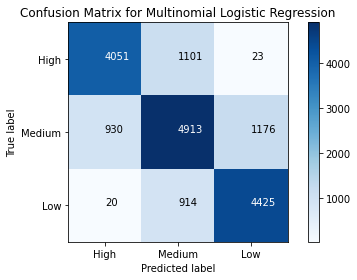

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5175
           1       0.66      0.67      0.67      7019
           2       0.77      0.72      0.74      5359

    accuracy                           0.72     17553
   macro avg       0.73      0.72      0.72     17553
weighted avg       0.72      0.72      0.72     17553



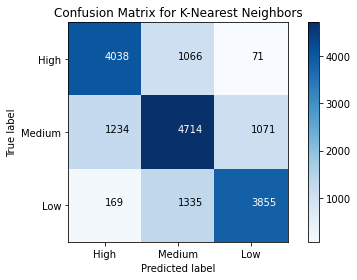

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5175
           1       0.77      0.80      0.78      7019
           2       0.86      0.85      0.86      5359

    accuracy                           0.82     17553
   macro avg       0.83      0.82      0.83     17553
weighted avg       0.82      0.82      0.82     17553



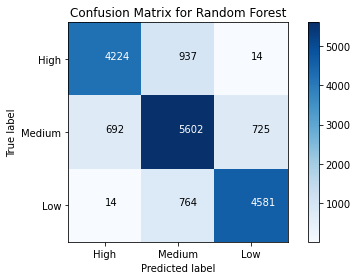

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      5175
           1       0.75      0.76      0.75      7019
           2       0.83      0.85      0.84      5359

    accuracy                           0.80     17553
   macro avg       0.81      0.81      0.81     17553
weighted avg       0.80      0.80      0.80     17553



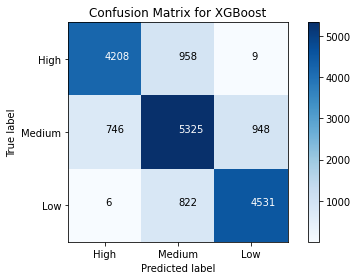

In [11]:
#Define a function for generating classification reports/ confusion matrices
def gen_confusion(classifier,y_val, y_pred):
    labels = [0,1,2] 
    print(classification_report(y_val, y_pred, labels)) #classification report from sklearn
    cnf_matrix = confusion_matrix(y_val, y_pred, labels=labels)
    plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
    threshold = cnf_matrix.max() / 2 #threshold to define text color
    for i in range(cnf_matrix.shape[0]): #print text in grid
        for j in range(cnf_matrix.shape[1]): 
            plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
    tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
    plt.xticks(tick_marks, labels=['High','Medium','Low'])
    plt.yticks(tick_marks, labels=['High','Medium','Low'])
    plt.title('Confusion Matrix for ' + str(classifier))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

for k,v in pred_dict.items():
    gen_confusion(k,y_val, v)

It's interesting to see the classification reports and the confusion matrix because we can get a sense of where the models err. A few observations:

* Multinomial Logistic Regression has a tendency to 'classify down' the reintegration potential scores - i.e. a good portion of 'high' reintegration potential offenders were predicted to be 'medium', and similarly for 'medium' individuals predicted as 'low'. Thus, this model has a tendency to underestimate the likelihood that an offender can successfully re-enter the community. 
* XGBoost was slightly better than Random Forest at handling extreme mistakes ('low' as 'high' or vice versa) but had pretty similar performance overall. 

ROC AUC

In [12]:
def get_auc(classifier,y_val, y_prob):
    roc = roc_auc_score(y_val, y_prob, multi_class="ovr", average="macro")
    print('ROC AUC score for ' + classifier + ": " + str(round(roc,3)))

prob_dict = {'Multinomial Logistic Regression':lr_prob, 
             'K-Nearest Neighbors':knn_prob, 
             'Random Forest':rf_prob, 
             'XGBoost':xgb_prob}

for k,v in prob_dict.items():
    get_auc(k,y_val,v)

ROC AUC score for Multinomial Logistic Regression: 0.903
ROC AUC score for K-Nearest Neighbors: 0.873
ROC AUC score for Random Forest: 0.941
ROC AUC score for XGBoost: 0.932


COmmentary

In [13]:
n_estimators = [10,100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30, 60, 100]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 3, 4, 5] 

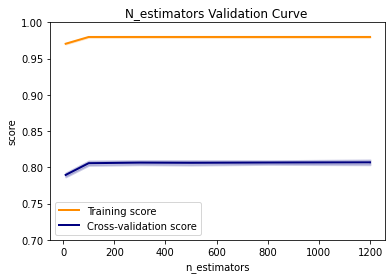

In [14]:
train_score, val_score = validation_curve(
                                rf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators, scoring='accuracy', cv = 3)

train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(val_score, axis=1)
test_scores_std = np.std(val_score, axis=1)

plt.title("N_estimators Validation Curve ")
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.ylim(0.7, 1.0)
lw = 2
plt.plot(n_estimators, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_estimators, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(n_estimators, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_estimators, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

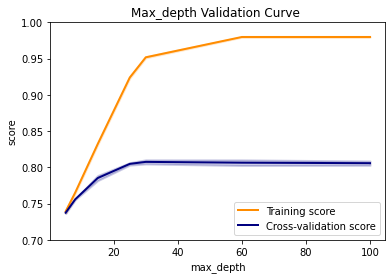

In [15]:
train_score, val_score = validation_curve(
                                rf,
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_depth, scoring='accuracy', cv = 3)

train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(val_score, axis=1)
test_scores_std = np.std(val_score, axis=1)

plt.title("Max_depth Validation Curve ")
plt.xlabel('max_depth')
plt.ylabel('score')
plt.ylim(0.7, 1.0)
lw = 2
plt.plot(max_depth, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(max_depth, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(max_depth, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(max_depth, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

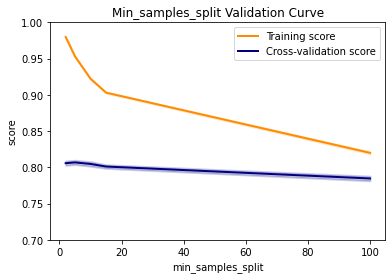

In [16]:
train_score, val_score = validation_curve(
                                rf,
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split, scoring='accuracy', cv = 3)

train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(val_score, axis=1)
test_scores_std = np.std(val_score, axis=1)

plt.title("Min_samples_split Validation Curve")
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.ylim(0.7, 1.0)
lw = 2
plt.plot(min_samples_split, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(min_samples_split, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(min_samples_split, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(min_samples_split, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

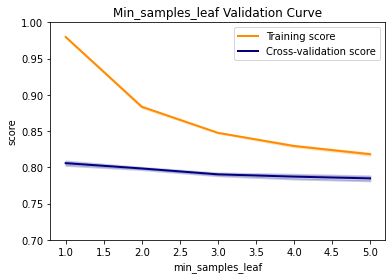

In [17]:
train_score, val_score = validation_curve(
                                rf,
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf, scoring='accuracy', cv = 3)

train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(val_score, axis=1)
test_scores_std = np.std(val_score, axis=1)

plt.title("Min_samples_leaf Validation Curve")
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.ylim(0.7, 1.0)
lw = 2
plt.plot(min_samples_leaf, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(min_samples_leaf, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(min_samples_leaf, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(min_samples_leaf, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Feature ranges:
- n_estimators: 80 - 400
- max_depth: 20-60
- min_samples_split: 0-20
- min_samples_leaf: 0-4

In [ ]:
# Outline the hyperparameter values we want to consider

n_estimators = [80,104,128,152,276,200]
max_depth = np.linspace(20, 60, 10, endpoint=True)
np.append(max_depth, None)
min_samples_split = [2,4,6,8,10]
min_samples_leaf = [1,2,3,4,5]

# Combine into a dictionary

parameters = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

# Instantiate GridSearch
gs_rf = GridSearchCV(rf, parameters, cv = 3, verbose = 1, 
                      n_jobs = -1, scoring='accuracy')

best_gs = gs_rf.fit(X_train, y_train)

# Get best parameters and best score

print(best_gs.best_score_)
print(best_gs.best_params_)

In [27]:
grf_pred, grf_prob = fit_model(RandomForestClassifier(n_estimators = 276, max_depth = 33.333333333333336, min_samples_split = 2, min_samples_leaf = 1, random_state=42), X_train, y_train, X_val)
print('Accuracy score for GridSearch RF: ' + str(round(accuracy_score(y_val, grf_pred),3)))


Accuracy score for GridSearch RF: 0.822


In [30]:
X_train_final = np.concatenate((X_train, X_val), axis=0)
y_train_final = np.concatenate((y_train, y_val), axis=0)

In [31]:
best_rf = RandomForestClassifier(n_estimators = 276, max_depth = 33.333333333333336, min_samples_split = 2, min_samples_leaf = 1, random_state=42)
best_rf.fit(X_train_final, y_train_final)

final_pred_w = best_rf.predict(X_test)
final_pred_nw = best_rf.predict(X_testtwo)

print('Accuracy score for white offender test set: ' + str(round(accuracy_score(y_test, final_pred_w),3)))
print('Accuracy score for non-white offender test set: ' + str(round(accuracy_score(y_testtwo, final_pred_nw),3)))

Accuracy score for white offender test set: 0.826
Accuracy score for non-white offender test set: 0.775


Option:
-Ordinal regression